# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally
written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you can select your final model/hyperparameters to run one time only and then make the business perfoemance tables for that final model.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [ ]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [ ]:
%%time
vars = pd.read_csv('vars_final_applications.csv')
print(vars.shape)
vars.head()

(1000000, 22)
CPU times: user 1.17 s, sys: 223 ms, total: 1.4 s
Wall time: 1.39 s


,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30,...,address_count_30,max_count_by_address_3,address_count_14,fulladdress_count_14,max_count_by_address_1,fulladdress_count_7,address_count_7,address_count_0_by_30,record,fraud_label
0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,9.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,1.0,0.0
1,1.0,1.0,1.0,1.0,4.0,1.0,1.0,11.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,2.0,1.0
2,1.0,1.0,1.0,1.0,3.0,1.0,1.0,7.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,3.0,0.0
3,1.0,1.0,1.0,1.0,4.0,1.0,1.0,9.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,4.0,0.0
4,1.0,1.0,1.0,1.0,4.0,1.0,1.0,8.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,5.0,0.0


In [ ]:
# set the number of variables desired here, and set the names of the y and record number properly
NVARS = 10
detect_rate = 0.03
vars.rename(columns={'record':'Recnum'},inplace=True)
vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'max_count_by_address_30',
 'max_count_by_ssn_dob_7',
 'homephone_count_7',
 'zip5_count_1',
 'max_count_by_homephone_3',
 'fulladdress_count_30',
 'max_count_by_fulladdress_7',
 'max_count_by_homephone_30',
 'fulladdress_day_since',
 'ssn_count_30']

In [ ]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30
0,1.0,0.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,9.0,0.0,1.0
1,2.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,11.0,0.0,1.0
2,3.0,0.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,7.0,0.0,1.0
3,4.0,0.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,9.0,0.0,1.0
4,5.0,0.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,8.0,0.0,1.0


In [ ]:
vars.shape

(1000000, 12)

In [ ]:
vars['Fraud'].sum()

14393.0

In [ ]:
vars.head(10)

,Recnum,Fraud,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30
0,1.0,0.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,9.0,0.0,1.0
1,2.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,11.0,0.0,1.0
2,3.0,0.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,7.0,0.0,1.0
3,4.0,0.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,9.0,0.0,1.0
4,5.0,0.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,8.0,0.0,1.0
5,6.0,0.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,12.0,0.0,1.0
6,7.0,0.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,8.0,0.0,1.0
7,8.0,0.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,0.0,1.0
8,9.0,0.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,11.0,0.0,1.0
9,10.0,0.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,12.0,0.0,1.0


In [ ]:
vars.shape

(1000000, 12)

In [ ]:
vars.describe()

,Recnum,Fraud,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,500000.500000,0.014393,1.199908,1.055732,1.935565,1.511174,3.315778,1.064739,1.084788,8.511320,39.952181,1.050924
std,288675.278933,0.119104,1.555354,0.772917,1.214552,0.960615,1.834058,0.633947,0.996835,4.039978,99.111297,0.513573
min,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,250000.750000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,7.000000,0.000000,1.000000
50%,500000.500000,0.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,9.000000,0.000000,1.000000
75%,750000.250000,0.000000,1.000000,1.000000,2.000000,2.000000,4.000000,1.000000,1.000000,11.000000,0.000000,1.000000
max,1000000.000000,1.000000,54.000000,34.000000,33.000000,33.000000,32.000000,30.000000,30.000000,50.000000,365.000000,34.000000


In [ ]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0.0
1,1.0
2,0.0
3,0.0
4,0.0


## Scale and truncate field values

In [ ]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,1.199908,1.055732,1.935565,1.511174,3.315778,1.064739,1.084788,8.511320,39.952181,1.050924
std,1.555354,0.772917,1.214552,0.960615,1.834058,0.633947,0.996835,4.039978,99.111297,0.513573
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,7.000000,0.000000,1.000000
50%,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,9.000000,0.000000,1.000000
75%,1.000000,1.000000,2.000000,2.000000,4.000000,1.000000,1.000000,11.000000,0.000000,1.000000
max,54.000000,34.000000,33.000000,33.000000,32.000000,30.000000,30.000000,50.000000,365.000000,34.000000


In [ ]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [ ]:
# use this to cap variables. For some problems it helps
Clip = 10

In [ ]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
X = (X - X.mean()) / X.std()
X.describe()

,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30
count,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
mean,-2.378897e-17,6.323830e-19,1.901235e-17,7.516121e-17,-3.606715e-17,-5.057821e-17,-4.071588e-17,-6.039613e-18,2.282263e-17,-7.723600e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.659633e-01,-9.468038e-02,-7.916143e-01,-5.723235e-01,-1.299119e+00,-1.328419e-01,-1.004119e-01,-1.861493e+00,-4.031042e-01,-1.385946e-01
25%,-1.659633e-01,-9.468038e-02,-7.916143e-01,-5.723235e-01,-1.748944e-01,-1.328419e-01,-1.004119e-01,-3.744425e-01,-4.031042e-01,-1.385946e-01
50%,-1.659633e-01,-9.468038e-02,5.704125e-02,-5.723235e-01,-1.748944e-01,-1.328419e-01,-1.004119e-01,1.212411e-01,-4.031042e-01,-1.385946e-01
75%,-1.659633e-01,-9.468038e-02,5.704125e-02,5.584938e-01,3.872181e-01,-1.328419e-01,-1.004119e-01,6.169247e-01,-4.031042e-01,-1.385946e-01
max,1.449903e+01,1.824326e+01,1.030972e+01,1.086853e+01,1.031208e+01,1.585223e+01,1.528096e+01,1.001288e+01,3.279624e+00,1.703702e+01


In [ ]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
oot_recnum=833507
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]

## Explore regularization

Solve a linear regression with ridge and lasso regularization and watch how the variable weights evolve with the regularization strength

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.metrics import mean_squared_error

In [ ]:
alphas = 10**np.linspace(2,9,30)*0.5

In [ ]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

In [ ]:
# %%time
# ridge = Ridge()
# coefs = []
# for a in alphas: 
#     ridge.set_params(alpha=a) 
#     ridge.fit(X_trn,Y_trn.values.ravel()) 
#     coefs.append(ridge.coef_) 
# print(np.shape(coefs))

# %matplotlib inline
# ax = plt.gca() # Get the current Axes instance
# ax.plot(alphas, coefs)
# ax.set_xscale('log')
# plt.xlabel('alpha') 
# plt.ylabel('standadized coef') 
# plt.title('Ridge')
# plt.savefig('ridge.png')

In [ ]:
# %%time
# # sometimes this cell takes a long time. It's fine to comment out this cell since it's not really important
# alphas = 10**np.linspace(-5,0,30)*0.5
# lasso = Lasso(max_iter=10000) 
# coefs = [] 
# for a in alphas: 
#     lasso.set_params(alpha=a) 
#     lasso.fit(X_trn,Y_trn.values.ravel()) 
#     coefs.append(lasso.coef_) 
# # print('Shape:',np.shape(coefs)
# print('Selected Features:', list(vars.columns[np.where(lasso.coef_!=0)[0]]))

# %matplotlib inline
# ax = plt.gca() # Get the current Axes instance 
# ax.plot(alphas, coefs)
# ax.set_xscale('log')
# plt.xlabel('alpha')
# plt.ylabel('standerdized coef') 
# plt.title('Lasso')
# plt.legend()
# plt.savefig('lasso.png')

## Look at PCA

In [ ]:
len(X_trntst.columns)

10

In [ ]:
X_trntst_save = X_trntst.copy()

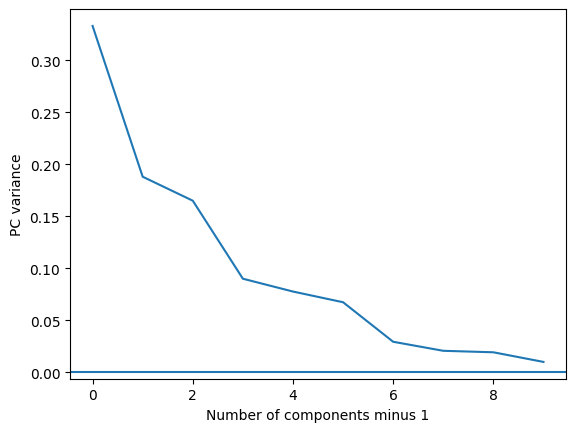

In [ ]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [ ]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 4, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4
0,-0.656019,0.074459,-0.097360,-0.281994
1,-0.387121,-0.479267,0.153415,-0.306019
2,-0.771736,0.344725,-0.229647,-0.266239
3,-0.502839,-0.209001,0.021128,-0.290264
4,-0.560697,-0.073869,-0.045015,-0.282387


In [ ]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4
833507,0.276820,-0.007242,0.361780,-1.569842
833508,-1.425248,1.722442,-0.863483,-0.202434
833509,2.900553,1.672622,1.952509,-2.343753
833510,-1.040633,0.898451,-0.480422,-0.242214
833511,-0.518356,0.383176,-0.434325,0.637870


In [ ]:
X_trntst.describe()

,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30
count,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000
mean,0.001982,-0.001123,-0.001046,-0.000449,-0.000264,0.000321,0.001752,0.000159,-0.031511,-0.001817
std,1.006220,0.989478,1.000361,1.003332,0.998779,1.004381,1.012285,0.999543,0.981284,0.988286
min,-0.165963,-0.094680,-0.791614,-0.572324,-1.299119,-0.132842,-0.100412,-1.861493,-0.403104,-0.138595
25%,-0.165963,-0.094680,-0.791614,-0.572324,-0.174894,-0.132842,-0.100412,-0.374442,-0.403104,-0.138595
50%,-0.165963,-0.094680,0.057041,-0.572324,-0.174894,-0.132842,-0.100412,0.121241,-0.403104,-0.138595
75%,-0.165963,-0.094680,0.057041,0.558494,0.387218,-0.132842,-0.100412,0.616925,-0.403104,-0.138595
max,14.499030,18.243255,10.309721,10.868526,10.312079,15.852230,15.280956,10.012880,3.279624,17.037019


In [ ]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,166493.000000,166493.000000,166493.000000,166493.000000
mean,0.040499,0.038348,0.032612,-0.094926
std,1.772191,1.387443,1.324092,0.976607
min,-1.425248,-13.212933,-11.223583,-4.715301
25%,-0.576214,-0.648659,-0.361934,-0.313897
50%,-0.191459,-0.081126,-0.031217,-0.259314
75%,0.246416,0.628185,0.264421,0.605015
max,31.842330,13.856326,24.419521,9.593413


In [ ]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [ ]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4
count,8.335070e+05,8.335070e+05,8.335070e+05,8.335070e+05
mean,-1.254841e-17,2.005018e-17,1.739046e-18,9.956892e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-7.819790e-01,-9.226548e+00,-9.227569e+00,-4.911662e+00
25%,-3.393010e-01,-4.890976e-01,-2.870571e-01,-3.065445e-01
50%,-1.282776e-01,-6.932942e-02,-3.605879e-02,-2.665453e-01
75%,1.033771e-01,4.337427e-01,1.922841e-01,6.486890e-01
max,1.759116e+01,1.321812e+01,1.937557e+01,1.497702e+01


In [ ]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,166493.000000,166493.000000,166493.000000,166493.000000
mean,0.022220,0.028006,0.025426,-0.100251
std,0.972333,1.013247,1.032345,1.031383
min,-0.781979,-9.649378,-8.750608,-4.979773
25%,-0.316147,-0.473714,-0.282186,-0.331502
50%,-0.105046,-0.059246,-0.024339,-0.273859
75%,0.135199,0.458762,0.206159,0.638949
max,17.470665,10.119246,19.038987,10.131489


In [ ]:
X_trntst_pca.shape

(833507, 4)

In [ ]:
X_oot_orig_pca.shape

(166493, 4)

## Subsample the larger class if desired

In [ ]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.0144053979150745
(23841, 10) 23841


In [ ]:
niter = 0
nitermax = 10
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and just explore one model type. You can also just rerun that single cell multiple times (hit shift-enter on that cell) as you manually explore different model hyperparameters.

In [ ]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [ ]:
%%time
# Logistic regression

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression()
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5995707130932506 0.6086716376691522 0.5704107292539815
1 0.5973336479471448 0.6137071651090342 0.5699916177703269
2 0.602182422013996 0.5970357941834452 0.5695725062866722
3 0.6018718502519799 0.6033215355295399 0.5708298407376362
4 0.6004273504273504 0.605916829472509 0.5708298407376362
5 0.6003101145038168 0.6022633176925201 0.5704107292539815
6 0.6068825427171705 0.5926333150082463 0.5704107292539815
7 0.6028954295285953 0.6004384762948753 0.5712489522212909
8 0.5978536114795611 0.6077005923532579 0.5691533948030176
9 0.5950314988707952 0.6168614357262103 0.5708298407376362
trn    0.600436
tst    0.604855
oot    0.570369
dtype: float64
CPU times: user 4min 58s, sys: 938 ms, total: 4min 59s
Wall time: 39.7 s


In [ ]:
%%time
# Single DT

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    mss = 60
    msl = int(mss/2)
    # model = DecisionTreeClassifier(max_depth=12,min_samples_split=mss,min_samples_leaf=msl)

    model = DecisionTreeClassifier(criterion='entropy',
                                   splitter='best',
                                   max_depth = 10,
                                   min_samples_split=100,
                                   min_samples_leaf=50
                                  )

 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 0.6206156048675734 0.6306206896551724 0.588013411567477
1 0.621727283497216 0.6256309590577678 0.586756077116513
2 0.6223047436511739 0.625034162339437 0.586756077116513
3 0.6216345578556899 0.6287671232876713 0.5888516345347863
4 0.6275143678160919 0.6147742818057456 0.5905280804694049
5 0.6253740275284261 0.6210295728368017 0.5875943000838223
6 0.6245344226841283 0.6210640608034745 0.586756077116513
7 0.6222619047619048 0.6257277515941225 0.5863369656328583
8 0.6265318262938727 0.6163242642976124 0.586756077116513
9 0.622607439508848 0.6267567567567568 0.5875943000838223
trn    0.623511
tst    0.623573
oot    0.587594
dtype: float64
CPU times: user 9.37 s, sys: 395 ms, total: 9.76 s
Wall time: 9.75 s


In [ ]:
# %%time
# # RF

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     mss = 60
#     msl = int(mss/2)
#     model = RandomForestClassifier(n_estimators=20,max_depth=12,min_samples_split=mss,min_samples_leaf=msl,max_features=8)
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['RF',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [ ]:
%%time
# LGBM

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    # model = lgb.LGBMClassifier(num_leaves=8,n_estimators=200, verbose = -1)

    model = lgb.LGBMClassifier(boosting_type='gbdt',
                               num_leaves=31,
                               max_depth=4,
                               learning_rate=0.1,
                               n_estimators=50,
                              verbosity =-1)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6213923901519613 0.6313246162592382 0.5913663034367141
1 0.6295367717287488 0.6119526301294409 0.5901089689857502
2 0.6205917159763313 0.6353668822041045 0.5901089689857502
3 0.6252679209335557 0.6206705458575783 0.5905280804694049
4 0.620154119739182 0.6338185890257558 0.5917854149203688
5 0.619492025989368 0.6352343308865048 0.5892707460184409
6 0.6224742998936548 0.6283860045146726 0.5896898575020956
7 0.630928325210983 0.6076794657762938 0.5901089689857502
8 0.6267520541324312 0.6175288126507639 0.5905280804694049
9 0.6254192620987062 0.6203880841760043 0.5909471919530596
trn    0.624201
tst    0.624235
oot    0.590444
dtype: float64
CPU times: user 1min 28s, sys: 3.55 s, total: 1min 32s
Wall time: 12.3 s


In [ ]:
# %%time
# # LGBM with SMOTE
# from imblearn.over_sampling import SMOTE

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
#     sm = SMOTE()
    
#     X_trn_sm, Y_trn_sm = sm.fit_resample(X_trn,Y_trn)
    
#     print(niter, X_trn.shape,Y_trn.shape)
#     print(niter, X_trn_sm.shape,Y_trn_sm.shape)
#     print(Y_trn.sum())
#     print(Y_trn_sm.sum())

#     model = lgb.LGBMClassifier(num_leaves=8,n_estimators=200)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn_sm, Y_trn_sm.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['LGBM with SMOTE',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [ ]:
%%time
# NN
# moderately slow

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    # model = MLPClassifier(hidden_layer_sizes=(10,10),alpha=.005,solver='adam',activation='relu',
    #                       max_iter=1000,learning_rate='adaptive',learning_rate_init=.007)

    model = MLPClassifier(hidden_layer_sizes=(10,8,6,4,2),
                          activation='relu',
                          solver='adam',
                          alpha=0.05,
                          learning_rate='constant',
                          max_iter=150)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6200742603904659 0.6139967195188628 0.5875943000838223
1 0.619058851279632 0.6196145124716553 0.5896898575020956
2 0.624296828246559 0.6103504928806134 0.5871751886001676
3 0.035023150896355215 0.032924107142857144 0.025146689019279127
4 0.6155115511551155 0.6329832529094521 0.5909471919530596
5 0.6224234481115215 0.6120641947980078 0.5901089689857502
6 0.6163357508025205 0.6223581757508343 0.5863369656328583
7 0.6196289646918013 0.624315443592552 0.5917854149203688
8 0.620262132483174 0.6167326172979084 0.586756077116513
9 0.6209476309226932 0.6104294478527608 0.5884325230511316
trn    0.561356
tst    0.559577
oot    0.532397
dtype: float64
CPU times: user 10min 10s, sys: 2.49 s, total: 10min 13s
Wall time: 7min 59s


In [ ]:
# %%time
# # NN on pc's

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = MLPClassifier(hidden_layer_sizes=(10,10),alpha=.005,solver='adam',activation='relu',
#                           max_iter=1000,learning_rate='adaptive',learning_rate_init=.01)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['NN_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [ ]:
# %%time
# # GBC

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = GradientBoostingClassifier(learning_rate=0.01,max_depth=4,n_estimators=300)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['GBC',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [ ]:
%%time
# Catboost

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = CatBoostClassifier(verbose=0, iterations=80, depth=5)
# #             learning_rate=0.03,
# #             l2_leaf_reg=5  
# #

    model = CatBoostClassifier(
                                iterations=300,
                                learning_rate=0.05,
                                depth=6,
                                l2_leaf_reg=3,
                                border_count=200,
                                random_seed=42,
                                verbose=False
                            )
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6185018903591682 0.6375952582557155 0.5905280804694049
1 0.623778889683107 0.6266260725159147 0.5892707460184409
2 0.6266398770830871 0.6206993795826283 0.5896898575020956
3 0.6213102951763859 0.6310917506125783 0.5892707460184409
4 0.6242076306661882 0.6236972024136039 0.5905280804694049
5 0.6274881516587678 0.6173254835996635 0.5896898575020956
6 0.625385527876631 0.6237070170533967 0.5905280804694049
7 0.6271607861709685 0.618646447627071 0.5905280804694049
8 0.6270551257253385 0.620615796519411 0.5896898575020956
9 0.6275596241869429 0.6180836707152496 0.5905280804694049
trn    0.624909
tst    0.623809
oot    0.590025
dtype: float64
CPU times: user 10min 49s, sys: 55.4 s, total: 11min 44s
Wall time: 1min 42s


In [ ]:
# %%time
# # NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# # Only use this cell if you do downsampling of the goods.
# # each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# # it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

# xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
# print(xmult)
# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)
    
# #     model = svm.SVC(
# #         C=.1, 
# # #         gamma=100,
# # #         kernel='linear',
# #         kernel='poly',
# #         probability=True)

#     model = CatBoostClassifier(verbose=0, iterations=100)
# #             learning_rate=0.03,
# #             l2_leaf_reg=5  
# #

#     model.fit(X_trn, Y_trn.values.ravel())  
    
#     X_oot = X_oot_orig.copy()
#     X_trn = X_trntst.copy()
#     Y_trn = Y_trntst.copy()
#     X_tst = X_trntst.copy()
#     Y_tst = Y_trntst.copy()


#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trntst['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_trntst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['cat boost_sampled',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [ ]:
%%time
# Catboost on pc's

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = CatBoostClassifier(verbose=0, iterations=80, depth=5)
# #             learning_rate=0.03,
# #             l2_leaf_reg=5  
# #

    model = CatBoostClassifier(
                                iterations=300,
                                learning_rate=0.05,
                                depth=6,
                                l2_leaf_reg=3,
                                border_count=200,
                                random_seed=42,
                                verbose=False
                            )
    X_oot = X_oot_orig_pca.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6198148370806781 0.6254742547425475 0.5863369656328583
1 0.6198230088495575 0.6257078142695357 0.5888516345347863
2 0.6210198707206129 0.6227758007117438 0.5888516345347863
3 0.619716632932492 0.6258314855875832 0.5884325230511316
4 0.6308566019876952 0.60028129395218 0.5871751886001676
5 0.6246242635565709 0.6143631436314363 0.5884325230511316
6 0.6213116712459682 0.6223872387238724 0.5875943000838223
7 0.6233532934131737 0.6179928903472792 0.5875943000838223
8 0.6207350652460194 0.6242474001094691 0.588013411567477
9 0.6263370572854766 0.6095185082104091 0.5871751886001676
trn    0.622759
tst    0.618858
oot    0.587846
dtype: float64
CPU times: user 10min 5s, sys: 54.7 s, total: 11min
Wall time: 1min 34s


In [ ]:
# %%time
# # unsupervised model using pc's. 

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     pow = 2
#     oop = 1/pow
#     predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['unsupervised outliers',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [ ]:
%%time
# XGB

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    # model = xgb.XGBClassifier(
    #     booster='gbtree',
    #     max_depth=5, 
    #     min_child_weight=75,
    #     gamma=0.01, 
    # )

    model = xgb.XGBClassifier(booster="gbtree",
                                learning_rate=0.01,
                                n_estimators=100,
                                max_depth=20,
                                gamma=8,
                                reg_lambda=3,
                              subsample=0.5
                             )

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['XGB',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6249399327246516 0.6185175128970948 0.5859178541492037
1 0.6229800380228137 0.6251740462266778 0.5871751886001676
2 0.6264698824094073 0.616389872039205 0.5875943000838223
3 0.6217286914765906 0.6279575741093283 0.5871751886001676
4 0.6229721728833629 0.6243683323975294 0.588013411567477
5 0.6250148051640412 0.6189674523007856 0.5884325230511316
6 0.6243054734602199 0.62119503945885 0.5875943000838223
7 0.6239316239316239 0.6198716159642758 0.5884325230511316
8 0.6260104612458393 0.6175243393602226 0.5875943000838223
9 0.6229566877460924 0.6249310535024821 0.586756077116513
trn    0.624131
tst    0.621490
oot    0.587469
dtype: float64
CPU times: user 1min 37s, sys: 755 ms, total: 1min 38s
Wall time: 17.3 s


In [ ]:
# %%time
# # Knn
# # Knn can be very slow with a lot of records.

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = KNeighborsClassifier(n_neighbors=8) 
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['Knn',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [ ]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(
#         C=.1, 
# #         gamma=100,
# #         kernel='linear',
#         kernel='poly',
#         probability=True)
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['SVM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

## Model comparison plots

In [ ]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,log reg,0.599571,0.608672,0.570411
1,log reg,0.597334,0.613707,0.569992
2,log reg,0.602182,0.597036,0.569573
3,log reg,0.601872,0.603322,0.57083
4,log reg,0.600427,0.605917,0.57083
5,log reg,0.60031,0.602263,0.570411
6,log reg,0.606883,0.592633,0.570411
7,log reg,0.602895,0.600438,0.571249
8,log reg,0.597854,0.607701,0.569153
9,log reg,0.595031,0.616861,0.57083


In [ ]:
df.shape

(70, 4)

In [ ]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name='Type', value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.599571
1,log reg,Trn,0.597334
2,log reg,Trn,0.602182
3,log reg,Trn,0.601872
4,log reg,Trn,0.600427


In [ ]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.599571
1,log reg,Trn,0.597334
2,log reg,Trn,0.602182
3,log reg,Trn,0.601872
4,log reg,Trn,0.600427


In [ ]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
                   mean       std      mean       std      mean       std
Model                                                                    
DT             0.623511  0.002324  0.623573  0.005170  0.587594  0.001280
LGBM           0.624201  0.004018  0.624235  0.010009  0.590444  0.000760
NN             0.561356  0.184953  0.559577  0.185183  0.532397  0.178239
XGB            0.624131  0.001503   0.62149  0.003875  0.587469  0.000766
cat boost      0.624909  0.003025  0.623809  0.006432  0.590025  0.000552
cat boost_PCs  0.622759  0.003620  0.618858  0.008495  0.587846  0.000819
log reg        0.600436  0.003316  0.604855  0.007344  0.570369  0.000639

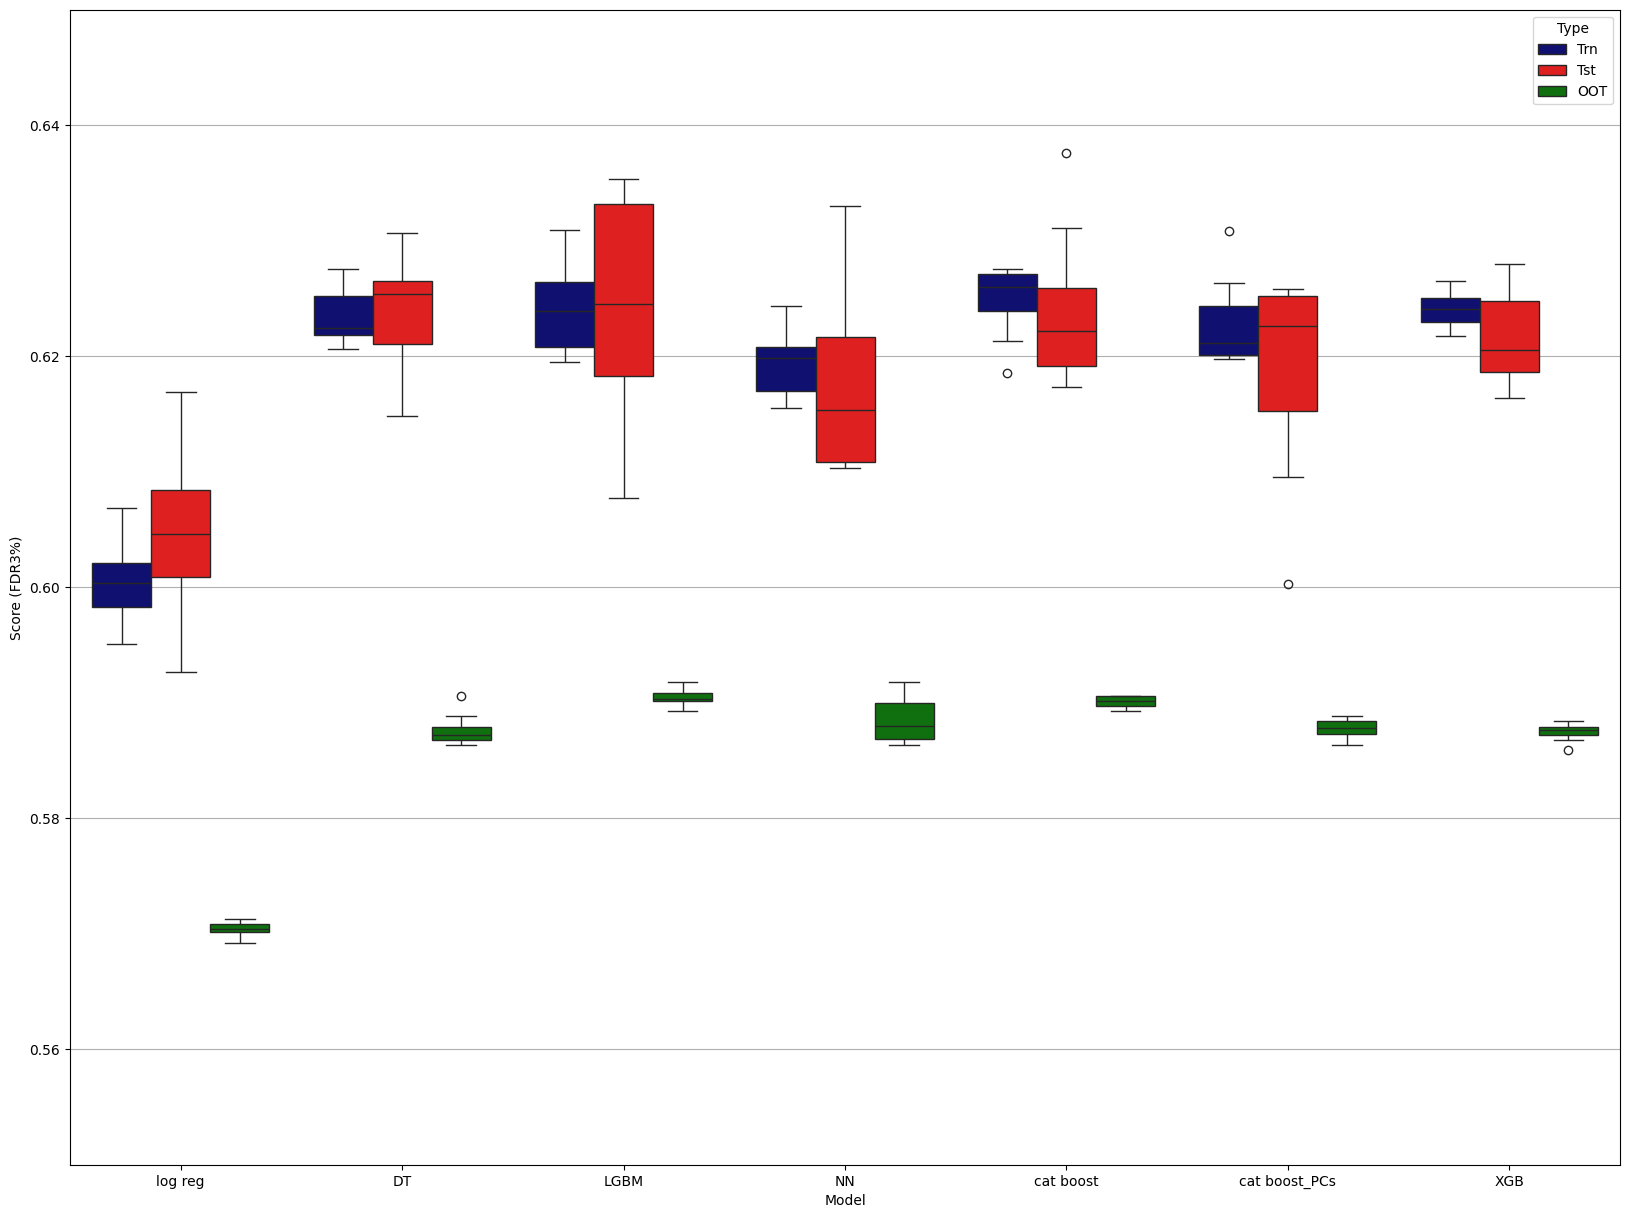

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.55,.65)
plt.ylabel('Score (FDR3%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [ ]:
print('duration: ', datetime.now() - start_time)

duration:  0:12:43.547286


The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [ ]:
%%time
# Note - need to set this next value to around the highest oot fdr for your model of choice.
# The model then runs a nomber of times with your fixed hyperparameters until it finds a good model.
# desire = best_OOT * .95
desire = .59
print('desire =', desire)
for niter in range(50):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
# I run this loop a large number of times with an unreasonably high stopping criterion (the break condition)
# I then look at all these runs and select a value of the oot performance where I want to break out this loop
# and that will be my final model run of choice
    model = xgb.XGBClassifier(booster="gbtree",
                                learning_rate=0.05,
                                n_estimators=30,
                                max_depth=7,
                                gamma=5,
                                reg_lambda=5
                             )

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
# choose a good break point
    if(FDR3.loc[niter, 'oot'] > desire): break

model_counter = model_counter + 1

desire = 0.59
0 0.6246740933870586 0.6158587839731017 0.5850796311818944
1 0.6215960217854606 0.627071047458579 0.5875943000838223
2 0.6282444549315715 0.6137071651090342 0.5875943000838223
3 0.625889890840057 0.6197261804973456 0.586756077116513
4 0.6234195911615267 0.6269751693002258 0.5884325230511316
5 0.6281187182215916 0.6138028169014085 0.588013411567477
6 0.6249554790454708 0.6180245535714286 0.5871751886001676
7 0.629848628192999 0.6108138552520417 0.5884325230511316
8 0.624837066003081 0.6219170403587444 0.586756077116513
9 0.626959619952494 0.6155561750766657 0.586756077116513
10 0.6223359923800452 0.6283259423503326 0.5875943000838223
11 0.6286904761904762 0.6132520099805933 0.5875943000838223
12 0.6247935833923095 0.621422499291584 0.5884325230511316
13 0.6263802208353336 0.6185034013605443 0.586756077116513
14 0.6299591247896129 0.6104635402548116 0.5875943000838223
15 0.6216408192257606 0.6289325842696629 0.5884325230511316
16 0.6249850995351055 0.6224433388612494 0.5888

In [ ]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [ ]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30,predicted,Fraud
996482,-0.165963,18.243255,1.754352,-0.572324,1.511443,-0.132842,-0.100412,1.856134,-0.403104,17.037019,0.791479,1.0
844749,-0.165963,18.243255,-0.791614,-0.572324,0.387218,-0.132842,-0.100412,0.616925,-0.403104,17.037019,0.791479,1.0
874235,-0.165963,18.243255,-0.791614,-0.572324,0.387218,-0.132842,-0.100412,0.121241,-0.403104,17.037019,0.791479,1.0
896601,-0.165963,18.243255,0.905697,0.558494,0.387218,-0.132842,-0.100412,0.616925,-0.403104,17.037019,0.791479,1.0
929001,-0.165963,18.243255,-0.791614,-0.572324,-0.737007,-0.132842,-0.100412,-0.374442,-0.403104,17.037019,0.791479,1.0
907123,-0.165963,18.243255,-0.791614,-0.572324,-0.737007,-0.132842,-0.100412,-1.365810,-0.403104,17.037019,0.791479,1.0
985386,-0.165963,16.394360,-0.791614,0.558494,-1.299119,-0.132842,-0.100412,-1.613651,-0.403104,17.037019,0.791479,1.0
984181,-0.165963,18.243255,0.057041,-0.572324,0.387218,-0.132842,-0.100412,0.616925,-0.403104,17.037019,0.791479,1.0
933089,-0.165963,18.243255,-0.791614,0.558494,0.949331,-0.132842,-0.100412,0.616925,-0.403104,17.037019,0.791479,1.0
968810,0.764944,18.243255,1.754352,2.820128,0.387218,2.363186,-0.100412,1.856134,2.987024,17.037019,0.791479,1.0


In [ ]:
cost_fraud = 4000
cost_fp = 100
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot

    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud
    FDR_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp
    FDR_trn.loc[i, 'Overall Savings'] = FDR_trn.loc[i, 'Fraud Savings'] - FDR_trn.loc[i, 'FP Loss']
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud
    FDR_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp
    FDR_tst.loc[i, 'Overall Savings'] = FDR_tst.loc[i, 'Fraud Savings'] - FDR_tst.loc[i, 'FP Loss']
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot

    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,1665.0,391.0,1274.0,23.483483,76.516517,1665.0,391.0,1274.0,0.238259,53.394803,53.156544,0.306907
2,2.0,1665.0,1561.0,104.0,93.753754,6.246246,3330.0,1952.0,1378.0,1.189468,57.753562,56.564095,1.416546
3,3.0,1665.0,1636.0,29.0,98.258258,1.741742,4995.0,3588.0,1407.0,2.186378,58.968986,56.782607,2.550107
4,4.0,1665.0,1653.0,12.0,99.279279,0.720721,6660.0,5241.0,1419.0,3.193648,59.471920,56.278271,3.693446
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,1665.0,1654.0,11.0,99.339339,0.660661,159833.0,157477.0,2356.0,95.959953,98.742666,2.782713,66.840832
97,97.0,1665.0,1657.0,8.0,99.519520,0.480480,161498.0,159134.0,2364.0,96.969660,99.077955,2.108295,67.315567
98,98.0,1665.0,1655.0,10.0,99.399399,0.600601,163163.0,160789.0,2374.0,97.978148,99.497066,1.518918,67.729149
99,99.0,1665.0,1657.0,8.0,99.519520,0.480480,164828.0,162446.0,2382.0,98.987855,99.832355,0.844500,68.197313


Max possible savings: 3,190,080,000.0


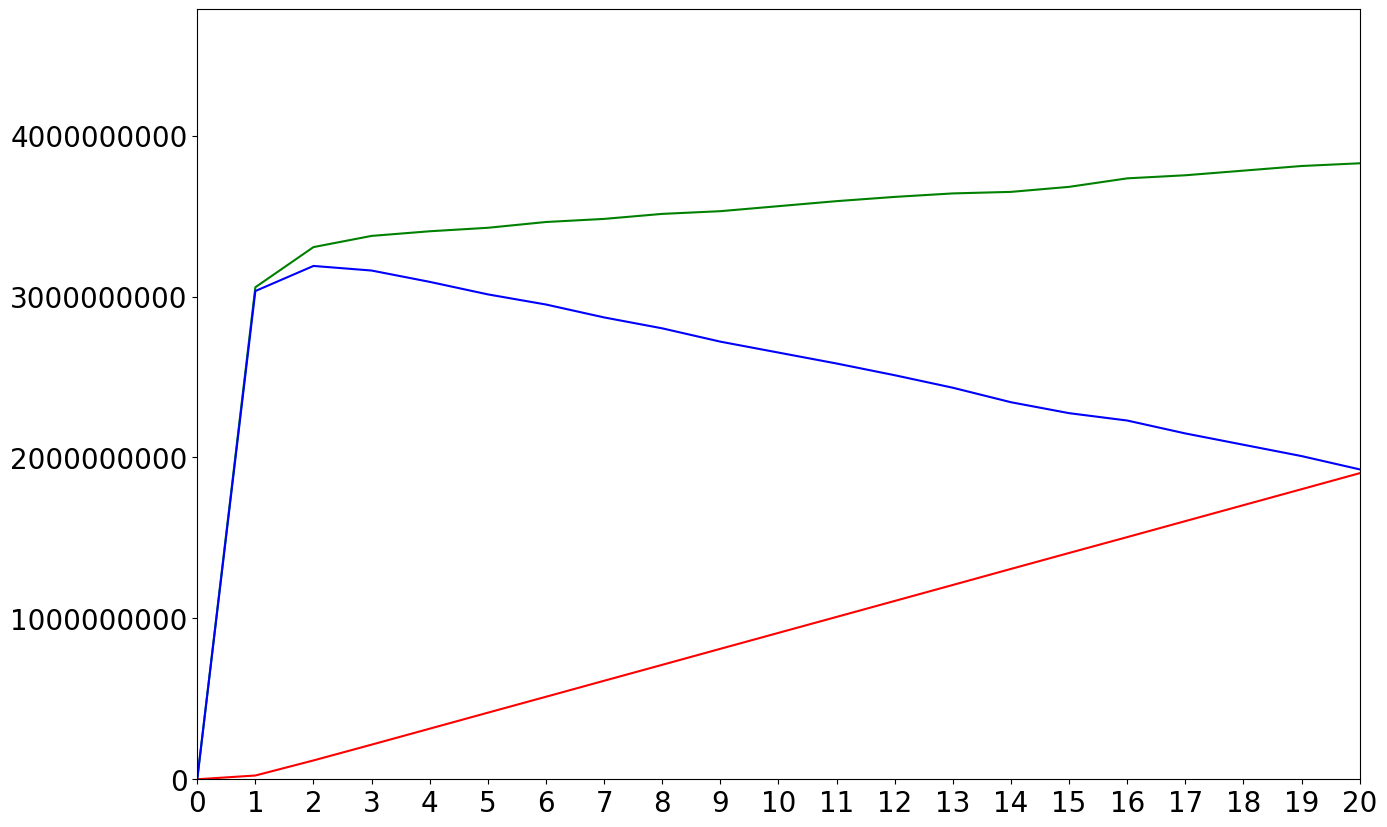

In [ ]:
# xmult: oot is only 2 out of 12 months. 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000
Financials_trn = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_tst = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud * xoot
    Financials_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp * xoot
    Financials_trn.loc[i, 'Overall Savings'] = Financials_trn.loc[i, 'Fraud Savings'] - Financials_trn.loc[i, 'FP Loss']
    Financials_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud * xoot
    Financials_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp * xoot
    Financials_tst.loc[i, 'Overall Savings'] = Financials_tst.loc[i, 'Fraud Savings'] - Financials_tst.loc[i, 'FP Loss']
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green')
plt.plot(Financials_oot['FP Loss'], color='red')
plt.plot(Financials_oot['Overall Savings'], color='blue')
xlimit = 20
interval = 1
plt.xlim(0,xlimit)
plt.ylim(0,yupper)
plt.xticks(ticks=np.linspace(0,xlimit, num=int(xlimit/interval)+1))
plt.ticklabel_format(style='plain')
plt.savefig('savings.png', format='png')

In [ ]:
FDR3.to_csv('FDR3.csv')

In [ ]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [ ]:
Metrics = FDR_oot.copy()
num_good = Metrics['#g'].sum()
num_bad = Metrics['#b'].sum()
num_tot = Metrics['#recs'].sum()
print(num_good,num_bad,num_good+num_bad,num_tot)

164107.0 2386.0 166493.0 166493.0


In [ ]:
Metrics['TP'] = Metrics['cb']
Metrics['TN'] = num_good - Metrics['cg']
Metrics['FN'] = num_bad - Metrics['cb']
Metrics['FP'] = Metrics['cg']
Metrics['Accuracy'] = (Metrics['TP'] + Metrics['TN']) / num_tot
Metrics['Misclass'] = (Metrics['FP'] + Metrics['FN']) / num_tot
Metrics['FPRate'] = Metrics['FP'] / (Metrics['FP'] + Metrics['TN'])
Metrics['FPRatio'] = Metrics['FP'] / Metrics['TP']
Metrics['TPR'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FN'])
Metrics['TNR'] = Metrics['TN'] / (Metrics['TN'] + Metrics['FP'])
Metrics['Precision'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FP'])
Metrics['f1'] = 2 * Metrics['Precision'] * Metrics['TPR'] / (Metrics['Precision'] + Metrics['TPR'])
Metrics.to_csv('Metrics.csv')

Text(0, 0.5, 'FDR')

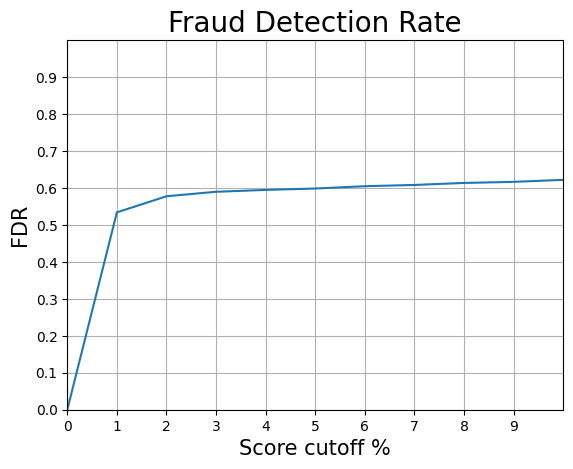

In [ ]:
plt.rcParams.update({'font.size':10})
plt.plot(Metrics['bin'], Metrics['TPR'])
plt.title('Fraud Detection Rate', fontsize=20)
plt.xlim(0,10)
plt.ylim(0,1)
plt.xticks(np.arange(0, 10, step=1))
plt.yticks(np.arange(0,1,step=.1))
plt.grid()
plt.xlabel('Score cutoff %', fontsize=15)
plt.ylabel('FDR', fontsize=15)

(0.0, 1.0)

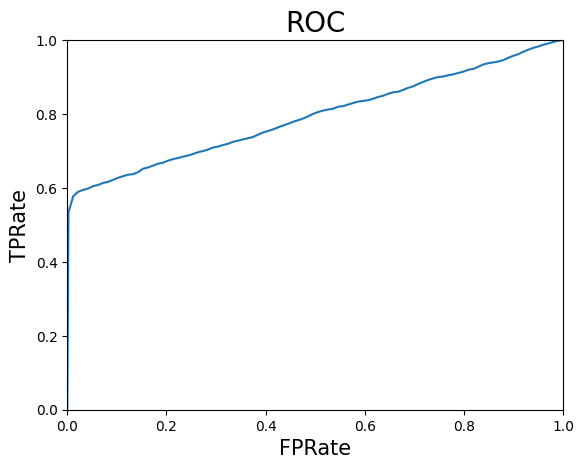

In [ ]:
plt.plot(Metrics['FPRate'], Metrics['TPR'])
plt.title('ROC', fontsize=20)
plt.xlabel('FPRate',fontsize=15)
plt.ylabel('TPRate', fontsize=15)
plt.xlim(0,1)
plt.ylim(0,1)

# Score Calibration

In [70]:
base = 800
delta = 30
odds_at_base = 1

In [71]:
df = pd.concat([X_trn_eval,X_tst_eval,X_oot_eval])
df.shape

(1000000, 12)

In [72]:
df.head()

,max_count_by_address_30,max_count_by_ssn_dob_7,homephone_count_7,zip5_count_1,max_count_by_homephone_3,fulladdress_count_30,max_count_by_fulladdress_7,max_count_by_homephone_30,fulladdress_day_since,ssn_count_30,predicted,Fraud
45881,-0.165963,-0.09468,-0.791614,0.558494,-0.737007,-0.132842,-0.100412,-0.622284,-0.403104,-0.138595,0.007599,0.0
709310,-0.165963,-0.09468,0.057041,0.558494,-0.737007,-0.132842,-0.100412,-0.870126,-0.403104,-0.138595,0.007599,0.0
679446,-0.165963,-0.09468,1.754352,-0.572324,0.387218,-0.132842,-0.100412,-0.126601,-0.403104,-0.138595,0.007426,1.0
137358,1.695851,-0.09468,0.057041,-0.572324,0.949331,-0.132842,-0.100412,0.616925,-0.403104,-0.138595,0.008802,0.0
522038,-0.165963,-0.09468,0.057041,-0.572324,0.387218,-0.132842,-0.100412,0.369083,-0.403104,-0.138595,0.007362,0.0


In [73]:
calib = df.iloc[:,df.shape[1]-2:]
trn_sorted = X_trn_eval.sort_values('predicted',ascending=True)
calib = calib.sort_values('predicted')
calib.rename(columns={'predicted':'score_raw'}, inplace=True)
calib['score_raw'].clip(upper=.999, inplace=True)
calib['score_raw'].clip(lower=.00001, inplace=True)
calib.head()

/tmp/ipykernel_3581/1461524955.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  calib['score_raw'].clip(upper=.999, inplace=True)
/tmp/ipykernel_3581/1461524955.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

,score_raw,Fraud
725123,0.007362,0.0
574142,0.007362,0.0
380763,0.007362,0.0
90861,0.007362,0.0
819062,0.007362,0.0


In [74]:
calib.shape

(1000000, 2)

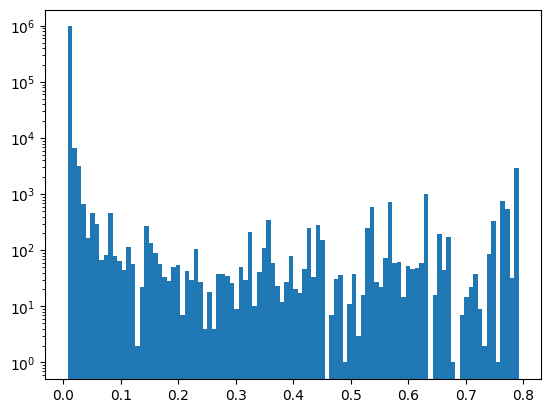

In [75]:
plt.hist(calib['score_raw'],bins=100)
plt.yscale('log')

In [76]:
# The reason we bin the records is to calculate the odds. We can then find the relationship between the raw score and the log odds.
nbins=500
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','score_raw','prob(%)','odds','log_odds', 'log_odds_adj']
cal_bins = pd.DataFrame(np.zeros((nbins+1, 14)), columns = cols)

In [77]:
bad_tot = sum(calib.loc[:, 'Fraud'])
good_tot = len(calib) - bad_tot
print(bad_tot, good_tot)

14393.0 985607.0


In [78]:
frac = 1/nbins
nrecs = calib.shape[0]
cal_bins.loc[0,'log_odds_adj'] = -8
for i in range(nbins+1):
    percent_rows_top = int(round(nrecs*frac*i))
    percent_rows_bottom = max(int(round(nrecs*frac*(i-1))),0)
    temp = calib.iloc[percent_rows_bottom:percent_rows_top,:]
    cal_bins.loc[i, 'score_raw'] = temp['score_raw'].mean()
    num_bad = int(sum(temp.loc[:,'Fraud']))
    num_tot = len(temp) * i
    num_good = int(num_tot - num_bad)
    cal_bins.loc[i, 'bin'] = i
    cal_bins.loc[i,'#recs'] = 0
    cal_bins.loc[i, 'tot'] = num_tot
    cal_bins.loc[i, 'cg'] = num_good
    cal_bins.loc[i, 'cb'] = num_bad
    if i != 0:
        cal_bins.loc[i, '#recs'] = len(temp)
        cal_bins.loc[i, '#b'] = int(sum(temp.loc[:, 'Fraud']))
        cal_bins.loc[i, '#g'] = cal_bins.loc[i, '#recs'] - cal_bins.loc[i, '#b']
        cal_bins.loc[i, '%g'] = 100* cal_bins.loc[i, '#g'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, '%b'] = 100 - cal_bins.loc[i, '%g']
        cal_bins.loc[i, 'cg'] = cal_bins.loc[i-1, 'cg'] + cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'cb'] = cal_bins.loc[i-1, 'cb'] + cal_bins.loc[i, '#b']
        cal_bins.loc[i, 'prob(%)'] = 100 * cal_bins.loc[i, '#b'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, 'odds'] = (cal_bins.loc[i, '#b'] + .001) / cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'log_odds'] = np.log2(cal_bins.loc[i, 'odds'])
        cal_bins.loc[i, 'log_odds_adj'] = max(cal_bins.loc[i, 'log_odds'], cal_bins.loc[i-1, 'log_odds_adj'])
        
cal_bins.drop(index=0,axis=0,inplace=True)
cal_bins.fillna(0)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
1,1.0,2000.0,1984.0,16.0,99.20,0.80,2000.0,1984.0,16.0,0.007362,0.80,0.008065,-6.954106,-6.954106
2,2.0,2000.0,1992.0,8.0,99.60,0.40,4000.0,3976.0,24.0,0.007362,0.40,0.004017,-7.959822,-6.954106
3,3.0,2000.0,1995.0,5.0,99.75,0.25,6000.0,5971.0,29.0,0.007362,0.25,0.002507,-8.639956,-6.954106
4,4.0,2000.0,1988.0,12.0,99.40,0.60,8000.0,7959.0,41.0,0.007362,0.60,0.006037,-7.372019,-6.954106
5,5.0,2000.0,1986.0,14.0,99.30,0.70,10000.0,9945.0,55.0,0.007362,0.70,0.007050,-7.148192,-6.954106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,496.0,2000.0,877.0,1123.0,43.85,56.15,992000.0,984506.0,7494.0,0.418351,56.15,1.280503,0.356710,0.356710
497,497.0,2000.0,631.0,1369.0,31.55,68.45,994000.0,985137.0,8863.0,0.566883,68.45,2.169574,1.117412,1.117412
498,498.0,2000.0,357.0,1643.0,17.85,82.15,996000.0,985494.0,10506.0,0.681168,82.15,4.602244,2.202337,2.202337
499,499.0,2000.0,77.0,1923.0,3.85,96.15,998000.0,985571.0,12429.0,0.774812,96.15,24.974039,4.642357,4.642357


In [79]:
cal_bins.tail(20)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
481,481.0,2000.0,1988.0,12.0,99.40,0.60,962000.0,956582.0,5418.0,0.009375,0.60,0.006037,-7.372019,-6.490330
482,482.0,2000.0,1977.0,23.0,98.85,1.15,964000.0,958559.0,5441.0,0.009667,1.15,0.011634,-6.425472,-6.425472
483,483.0,2000.0,1977.0,23.0,98.85,1.15,966000.0,960536.0,5464.0,0.010502,1.15,0.011634,-6.425472,-6.425472
484,484.0,2000.0,1984.0,16.0,99.20,0.80,968000.0,962520.0,5480.0,0.011661,0.80,0.008065,-6.954106,-6.425472
485,485.0,2000.0,1987.0,13.0,99.35,0.65,970000.0,964507.0,5493.0,0.012735,0.65,0.006543,-7.255825,-6.425472
486,486.0,2000.0,1970.0,30.0,98.50,1.50,972000.0,966477.0,5523.0,0.013418,1.50,0.015229,-6.037041,-6.037041
487,487.0,2000.0,1974.0,26.0,98.70,1.30,974000.0,968451.0,5549.0,0.013853,1.30,0.013172,-6.246411,-6.037041
488,488.0,2000.0,1975.0,25.0,98.75,1.25,976000.0,970426.0,5574.0,0.014221,1.25,0.012659,-6.303723,-6.037041
489,489.0,2000.0,1971.0,29.0,98.55,1.45,978000.0,972397.0,5603.0,0.016022,1.45,0.014714,-6.086681,-6.037041
490,490.0,2000.0,1946.0,54.0,97.30,2.70,980000.0,974343.0,5657.0,0.017692,2.70,0.027750,-5.171382,-5.171382


In [80]:
temp = cal_bins.copy()
temp.drop(columns=['bin','log_odds_adj','%g','%b','tot','cg','cb'], inplace=True)
temp.tail(10)

,#recs,#g,#b,score_raw,prob(%),odds,log_odds
491,2000.0,1969.0,31.0,0.017745,1.55,0.015745,-5.989005
492,2000.0,1961.0,39.0,0.022185,1.95,0.019888,-5.651935
493,2000.0,1914.0,86.0,0.028587,4.30,0.044933,-4.476094
494,2000.0,1867.0,133.0,0.047655,6.65,0.071238,-3.811213
495,2000.0,1575.0,425.0,0.167267,21.25,0.269842,-1.889814
496,2000.0,877.0,1123.0,0.418351,56.15,1.280503,0.356710
497,2000.0,631.0,1369.0,0.566883,68.45,2.169574,1.117412
498,2000.0,357.0,1643.0,0.681168,82.15,4.602244,2.202337
499,2000.0,77.0,1923.0,0.774812,96.15,24.974039,4.642357
500,2000.0,36.0,1964.0,0.789245,98.20,54.555583,5.769655


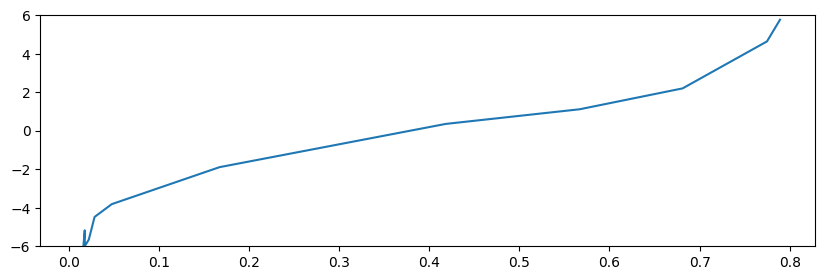

In [81]:
plt.figure(figsize=(10,3))
plt.plot(cal_bins['score_raw'],cal_bins['log_odds'])
# plt.plot(cal_bins['score_raw'],cal_bins['log_odds_adj'])
# plt.xlim([0,1])
plt.ylim([-6,6])
plt.show()

In [82]:
def funcg(x, a, b, c):
    return c + b/(1 + np.exp(-a * x))

def funcf(x, a, b, c):
    return -np.log(-1 + b/(x - c))/a

In [83]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(funcg, cal_bins['log_odds_adj'],cal_bins['score_raw'])   
print(popt)

[0.74468367 0.79695029 0.00194249]


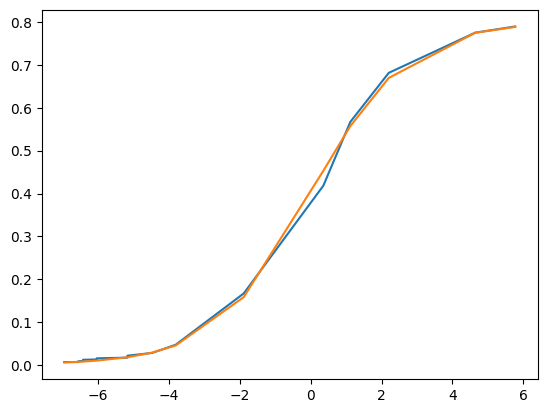

In [84]:
# plt.plot(cal_bins['log_odds'],cal_bins['score'])
plt.plot(cal_bins['log_odds_adj'],cal_bins['score_raw'])
plt.plot(cal_bins['log_odds_adj'],funcg(cal_bins['log_odds_adj'], *popt))

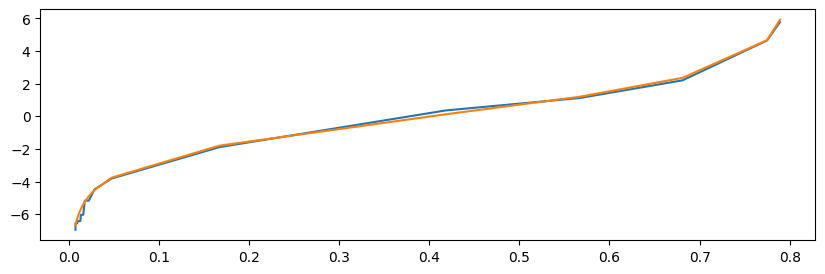

In [85]:
# look at the smooth curve fit to see if it's OK.
plt.figure(figsize=(10,3))
plt.plot(cal_bins['score_raw'], cal_bins['log_odds_adj'])
plt.plot(cal_bins['score_raw'], funcf(cal_bins['score_raw'], *popt))

In [86]:
# The fit looks pretty good
cal_bins['fit'] = funcf(cal_bins['score_raw'], *popt)
cal_bins.head(10)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj,fit
1,1.0,2000.0,1984.0,16.0,99.20,0.80,2000.0,1984.0,16.0,0.007362,0.80,0.008065,-6.954106,-6.954106,-6.692682
2,2.0,2000.0,1992.0,8.0,99.60,0.40,4000.0,3976.0,24.0,0.007362,0.40,0.004017,-7.959822,-6.954106,-6.692682
3,3.0,2000.0,1995.0,5.0,99.75,0.25,6000.0,5971.0,29.0,0.007362,0.25,0.002507,-8.639956,-6.954106,-6.692682
4,4.0,2000.0,1988.0,12.0,99.40,0.60,8000.0,7959.0,41.0,0.007362,0.60,0.006037,-7.372019,-6.954106,-6.692682
5,5.0,2000.0,1986.0,14.0,99.30,0.70,10000.0,9945.0,55.0,0.007362,0.70,0.007050,-7.148192,-6.954106,-6.692682
6,6.0,2000.0,1993.0,7.0,99.65,0.35,12000.0,11938.0,62.0,0.007362,0.35,0.003513,-8.153165,-6.954106,-6.692682
7,7.0,2000.0,1992.0,8.0,99.60,0.40,14000.0,13930.0,70.0,0.007362,0.40,0.004017,-7.959822,-6.954106,-6.692682
8,8.0,2000.0,1990.0,10.0,99.50,0.50,16000.0,15920.0,80.0,0.007362,0.50,0.005026,-7.636480,-6.954106,-6.692682
9,9.0,2000.0,1990.0,10.0,99.50,0.50,18000.0,17910.0,90.0,0.007362,0.50,0.005026,-7.636480,-6.954106,-6.692682
10,10.0,2000.0,1989.0,11.0,99.45,0.55,20000.0,19899.0,101.0,0.007362,0.55,0.005531,-7.498265,-6.954106,-6.692682


In [87]:
# Here's the calibrated score
cal_bins['score_calib'] = base + delta * cal_bins['fit'] - delta * np.log2(odds_at_base)
cal_bins['score_calib'].fillna(999, inplace=True)
cal_bins['score_calib'].clip(upper=999, inplace=True)

/tmp/ipykernel_3581/1415719438.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cal_bins['score_calib'].fillna(999, inplace=True)
/tmp/ipykernel_3581/1415719438.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [88]:
pd.set_option('display.max_rows', 100)
cal_bins.to_csv('cal_bins.csv')
cal_bins.tail(30)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj,fit,score_calib
471,471.0,2000.0,1988.0,12.0,99.40,0.60,942000.0,936749.0,5251.0,0.008802,0.60,0.006037,-7.372019,-6.558170,-6.373771,608.786874
472,472.0,2000.0,1990.0,10.0,99.50,0.50,944000.0,938739.0,5261.0,0.008993,0.50,0.005026,-7.636480,-6.558170,-6.336569,609.902921
473,473.0,2000.0,1985.0,15.0,99.25,0.75,946000.0,940724.0,5276.0,0.009284,0.75,0.007557,-7.047937,-6.558170,-6.281810,611.545693
474,474.0,2000.0,1981.0,19.0,99.05,0.95,948000.0,942705.0,5295.0,0.009284,0.95,0.009592,-6.704010,-6.558170,-6.281810,611.545693
475,475.0,2000.0,1982.0,18.0,99.10,0.90,950000.0,944687.0,5313.0,0.009284,0.90,0.009082,-6.782736,-6.558170,-6.281810,611.545693
476,476.0,2000.0,1987.0,13.0,99.35,0.65,952000.0,946674.0,5326.0,0.009284,0.65,0.006543,-7.255825,-6.558170,-6.281810,611.545693
477,477.0,2000.0,1981.0,19.0,99.05,0.95,954000.0,948655.0,5345.0,0.009284,0.95,0.009592,-6.704010,-6.558170,-6.281810,611.545693
478,478.0,2000.0,1978.0,22.0,98.90,1.10,956000.0,950633.0,5367.0,0.009284,1.10,0.011123,-6.490330,-6.490330,-6.281810,611.545693
479,479.0,2000.0,1982.0,18.0,99.10,0.90,958000.0,952615.0,5385.0,0.009334,0.90,0.009082,-6.782736,-6.490330,-6.272613,611.821617
480,480.0,2000.0,1979.0,21.0,98.95,1.05,960000.0,954594.0,5406.0,0.009364,1.05,0.010612,-6.558170,-6.490330,-6.267087,611.987390


In [89]:
calib.head()

,score_raw,Fraud
725123,0.007362,0.0
574142,0.007362,0.0
380763,0.007362,0.0
90861,0.007362,0.0
819062,0.007362,0.0


In [90]:
calib['score_calib'] = base - delta * np.log2(odds_at_base) + delta * funcg(calib['score_raw'], *popt)
calib['score_calib'].fillna(999, inplace=True)
calib['score_calib'].clip(upper=999, inplace=True)
calib.head()

/tmp/ipykernel_3581/2868135245.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  calib['score_calib'].fillna(999, inplace=True)
/tmp/ipykernel_3581/2868135245.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

,score_raw,Fraud,score_calib
725123,0.007362,0.0,812.045288
574142,0.007362,0.0,812.045288
380763,0.007362,0.0,812.045288
90861,0.007362,0.0,812.045288
819062,0.007362,0.0,812.045288


In [91]:
calib.tail()

,score_raw,Fraud,score_calib
144976,0.791479,1.0,815.43689
748240,0.791479,1.0,815.43689
691643,0.791479,1.0,815.43689
125087,0.791479,1.0,815.43689
642592,0.791479,1.0,815.43689


In [92]:
calib.describe()

,score_raw,Fraud,score_calib
count,1000000.000000,1000000.000000,1000000.000000
mean,0.014521,0.014393,812.076782
std,0.065610,0.119104,3.589326
min,0.007362,0.000000,812.045288
25%,0.007362,0.000000,812.045288
50%,0.007426,0.000000,812.045593
75%,0.007599,0.000000,812.046326
max,0.791479,1.000000,815.436890


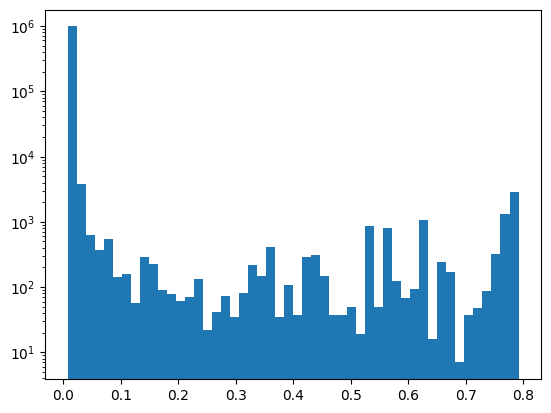

In [93]:
nbins=50
plt.hist(calib['score_raw'],bins=nbins)
plt.yscale('log')

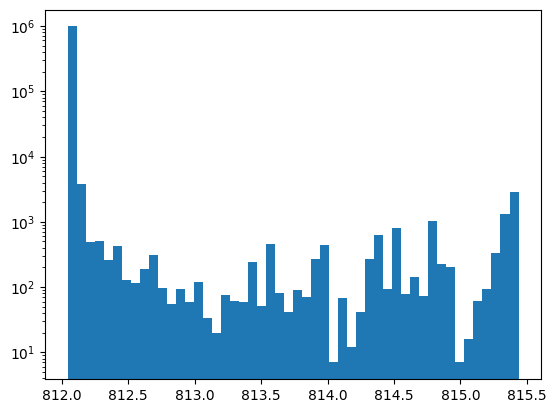

In [94]:
plt.hist(calib['score_calib'],bins=nbins)
plt.yscale('log')

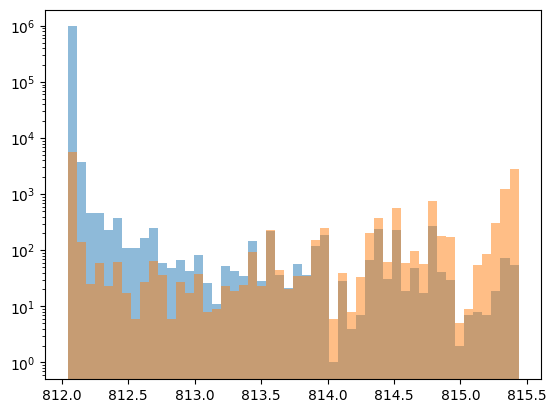

In [95]:
goods = calib[calib['Fraud']==0]
bads = calib[calib['Fraud']==1]
plt.hist(goods['score_calib'],bins = nbins, alpha = .5)
plt.hist(bads['score_calib'],bins = nbins, alpha = .5)
plt.yscale('log')

In [96]:
print("duration: ", datetime.now() - start_time)

duration:  0:20:02.820678
